# 1. Introduction

Imbalanced data classification is a hard task faced by Data Scientists. Let us stick to an example of identying whether a transaction is fradulent (1's) or not (0's). In this case, let us assume that the dataset has 99.9% regular transactions and 0.1% fraud transactions. On a daily basis, 100K transactions are reported to the bank. Out of that, 100 transactions every day are reported as fraud and the rest are regular transactions. Such a small number is very tough to predict. We will use the example below to demonstrate that and go through solutions prevalent today to tackle these problems. And we will also, understand why accuracy is not a good metric to use in this type of exercise. 

Finally, I have demonstrated an deep learning based data augmentation use case to apply for a problem of this type.

# 2. Understand the dataset

For this entire blog, we will use an example dataset from Kaggle. https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('creditcard.csv')

In [2]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

As we can see here, out of the __284K transactions reported to the bank, less than 500 are fraud transations.__

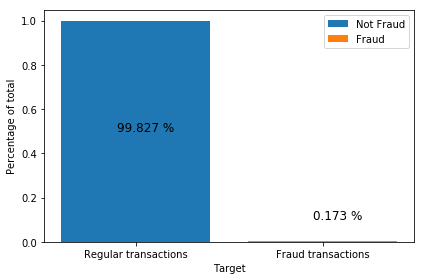

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

ratio_ones = df.Class.mean()
ratio_zeros = (len(df) - df.Class.sum())/len(df)

plt.bar('Regular transactions', height=ratio_zeros, label='Not Fraud')
plt.bar('Fraud transactions', height=ratio_ones, label='Fraud')
plt.xlabel("Target")
plt.ylabel('Percentage of total')
plt.text(-0.10, 0.5, "{0:.3f} %".format(ratio_zeros*100), fontsize=12)
plt.text(0.95, 0.1, "{0:.3f} %".format(ratio_ones*100), fontsize=12)
plt.legend()
plt.tight_layout()

## 2.1 More information about the data.

So out of the 284K transactions, only 492 are fraud transaction. "This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise." - Source - Kaggle.

## 2.2 Check each column statistics

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2.3 Correlation analysis

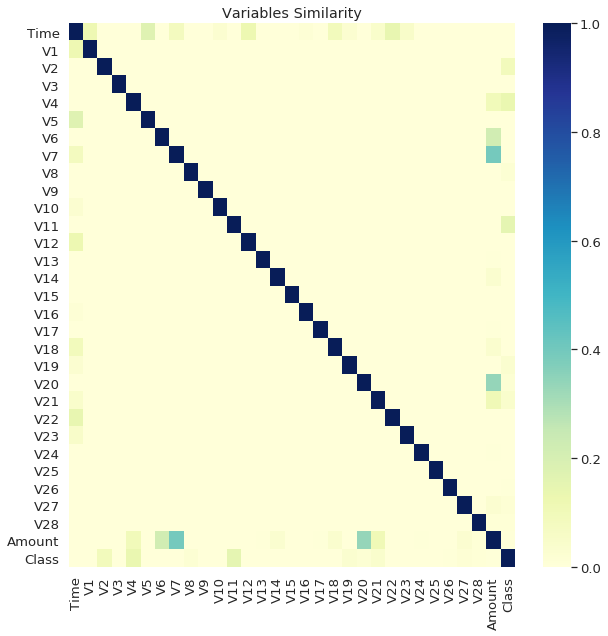

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10,10))
def plot_similarity(labels, features, rotation):
    corr = features.corr()
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlGnBu")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Variables Similarity")

plot_similarity(df.columns, df, 90)

As we can see from the above correlation analysis, the columns are having low correlation values and that is what PCA does again. We are good here. 

## 2.4 Histograms of few variables

By looking at the describe statistics in 2.2, the variables that needed a closer look are the Time and the amount variable. PCA variables (V1, V28) are centered around 0 and does not have outlier impact as we see. So we will look at the histogram of Time and Amount variable. 

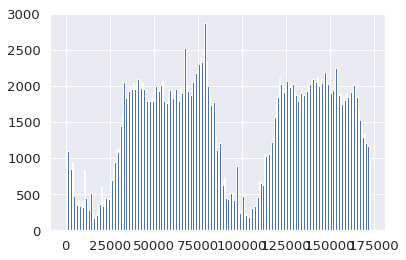

In [8]:
df.Time.hist(bins=200)

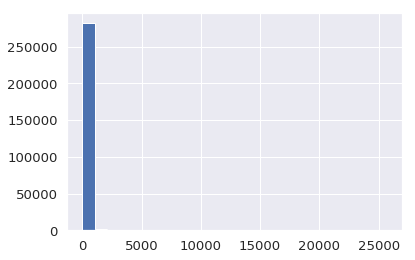

In [9]:
df.Amount.hist(bins=25)

Amount variable as we see here, has outliers. __May be there is a possibility that fraud transactions are associated with higher transaction amount. Let us look whether that is true with a simple cross tab.__

## 2.5 Cross tab of Amount and target variable

In [10]:
transaction_amount_threshold = 1000
amount_flag = ((df.Amount > transaction_amount_threshold).astype(int))
amount_flag.value_counts()

0    281867
1      2940
Name: Amount, dtype: int64

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(amount_flag, df.Class)

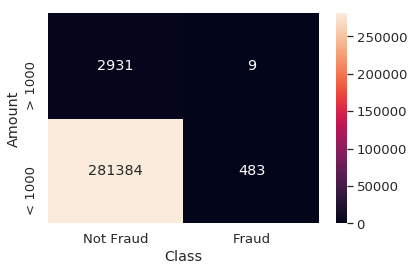

In [12]:
sns.heatmap(cm, annot=True, yticklabels=['< ' + str(transaction_amount_threshold),
                                        '> ' + str(transaction_amount_threshold)], 
                            xticklabels=['Not Fraud', 'Fraud'], fmt='g')
yl = plt.ylabel("Amount")
xl = plt.xlabel("Class")
plt.ylim([0,2])
plt.tight_layout()

From the analysis above, we see that __0.3% (9/2940) of transactions__ above 1000 dollars is fraud, when compared to __0.17% (483/281867) of transactions__ less than 1000 dollars. 

Now, we have a good sense of the data, let us go ahead and start the modeling process.

# 3. Modeling process - Feature selection

Since we are going to use these steps more often, let us make a function of each steps.

In [13]:
df.drop(['Time'], axis=1, inplace=True)

In [14]:
from xverse.feature_subset import SplitXY

def splitXY(df, target_column):

    clf = SplitXY([target_column]) #Split the dataset into X and y
    X, y = clf.fit_transform(df) #returns features (X) dataset and target(Y) as a numpy array
    return X, y

In [15]:
def make_train_test_split(X=None, y=None, test_size=0.3, random_state=1234):

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [16]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1234)

In [17]:
X_train.shape

(199364, 29)

In [18]:
y_train.shape

(199364,)

In [19]:
np.sum(y_train)

351

In [20]:
np.sum(y_test)

141

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## 3.1 Missing values check on each column

In [22]:
X_train.isnull().sum()

Amount    0
V1        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V2        0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
dtype: int64

No missing values in attributes in training data. We are good here

## 3.2 Check unary values a.k.a Cardinality of each columns

If a column is having unique values, then it is not going to provide any value. So we can ignore that column. 

In [23]:
X_train.nunique()

Amount     27420
V1        194227
V10       194227
V11       194227
V12       194227
V13       194227
V14       194227
V15       194227
V16       194227
V17       194227
V18       194227
V19       194227
V2        194227
V20       194227
V21       194227
V22       194227
V23       194227
V24       194227
V25       194227
V26       194227
V27       194227
V28       194227
V3        194227
V4        194227
V5        194227
V6        194227
V7        194227
V8        194227
V9        194227
dtype: int64

Again, we are good in cardinality of each columns. 

## 3.3 Feature selection part on unbalanced data

I am going to use the package that I developed for feature selection. It is called Xverse. 

In [24]:
from xverse.ensemble import VotingSelector

clf = VotingSelector()
clf.fit(X_train, y_train)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=14,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [25]:
clf.feature_importances_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One
0,V4,2.586234,0.024613,0.652387,0.041112,55.983400,0.020578
1,V12,2.026927,0.169729,0.000000,0.106979,26.871040,-0.035729
2,V14,2.026894,0.102770,-0.641298,0.109650,28.935596,-0.051818
3,V3,1.827990,0.015191,0.000000,0.036567,11.357897,0.000000
4,V11,1.729241,0.058821,0.000000,0.070802,61.477575,0.017455
5,V10,1.650776,0.064058,-0.674103,0.086695,9.067674,-0.037693
6,V16,1.303015,0.067169,0.000000,0.081707,19.818986,-0.030742
7,V2,1.167644,0.011552,0.000000,0.016568,0.604488,-0.009572
8,V17,1.154955,0.205636,0.000000,0.129953,18.866440,-0.048157
9,V9,1.055761,0.027648,-0.237577,0.034872,5.706094,-0.022785


In [26]:
clf.feature_votes_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One,Votes
0,V4,1,1,1,1,1,1,6
5,V10,1,1,1,1,1,1,6
13,V18,1,1,1,1,1,1,6
9,V9,1,1,1,1,1,1,6
2,V14,1,1,1,1,1,1,6
4,V11,1,1,0,1,1,1,5
6,V16,1,1,0,1,1,1,5
8,V17,1,1,0,1,1,1,5
10,V7,1,1,0,1,1,1,5
11,V21,1,1,1,1,0,1,5


As we see from the feature importance test above, the variable with atleast 2 votes are given below

In [27]:
vars_selected_unbalanced = clf.feature_votes_[clf.feature_votes_['Votes'] >= 2]['Variable_Name']
print(vars_selected_unbalanced)

0      V4
5     V10
13    V18
9      V9
2     V14
4     V11
6     V16
8     V17
10     V7
11    V21
1     V12
3      V3
12     V1
7      V2
20    V19
18     V8
Name: Variable_Name, dtype: object


## 3.4 Feature selection on balanced dataset

We want to verify if balancing the dataset is going to have an impact on the feature selection exercise. So, let us try it out.

In [28]:
df_train = X_train.copy(deep=True)
df_train['Class'] = y_train

In [29]:
df_train.head()

,Amount,V1,V10,V11,V12,V13,V14,V15,V16,V17,...,V27,V28,V3,V4,V5,V6,V7,V8,V9,Class
251474,62.59,2.204826,1.528504,-0.875710,-0.360018,1.201173,-0.532374,-0.252210,-0.702020,0.513988,...,0.008199,-0.042599,-0.950349,-1.446352,-1.288669,-0.944644,-0.879049,-0.342350,-1.357151,0
174014,16.37,-1.865275,0.939435,1.076229,-0.955163,-2.370698,-0.919738,1.043154,-0.771236,1.024570,...,-1.072025,-0.922523,-0.533463,-0.311065,2.218740,1.217010,0.511824,-0.144187,0.756047,0
250753,24.99,2.158823,0.107461,-0.964321,-1.698357,-1.167466,-1.855577,0.614191,1.835068,1.322913,...,0.016032,-0.011472,-1.443965,-0.740874,-0.531776,-0.388217,-1.049460,0.055527,0.299363,0
120732,61.18,1.169197,-0.500620,-1.394811,0.762854,0.996538,-0.765934,-0.330784,0.089963,-0.207528,...,-0.039022,0.016817,0.752087,0.089469,-0.769250,0.125516,-0.540502,0.043293,1.125848,0
79455,3.14,1.432821,0.668496,0.429527,0.304261,0.542571,-0.359518,-1.260906,0.883564,0.141600,...,0.005474,-0.010294,0.037679,-0.768158,-0.502799,-0.091228,-0.546729,-0.038278,-0.788374,0


In [30]:
df_zeros = df_train[df_train.Class == 0]
df_ones = df_train[df_train.Class == 1]

In [31]:
len(df_ones)

351

In [32]:
new_df_zeros = df_zeros.sample(n=351)

In [33]:
final_df_balanced_train = pd.concat([new_df_zeros, df_ones])

In [34]:
final_df_balanced_train.Class.value_counts()

1    351
0    351
Name: Class, dtype: int64

In [35]:
new_X, new_y = splitXY(final_df_balanced_train, 'Class')

from xverse.ensemble import VotingSelector

clf = VotingSelector()
clf.fit(new_X, new_y)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=14,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [36]:
clf.feature_importances_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One
0,V11,4.714481,0.050539,0.480636,0.070904,36.764009,0.020609
1,V12,4.380598,0.065307,-0.520700,0.096319,20.459661,-0.082264
2,V10,3.735998,0.151407,-0.322109,0.052467,7.280160,-0.016287
3,V3,3.590025,0.059815,0.000000,0.067398,8.637917,-0.024939
4,V16,3.126913,0.062936,0.000000,0.056640,14.017791,0.000000
5,V4,3.019944,0.110650,0.798333,0.088501,33.012025,0.097215
6,V7,2.422783,0.036327,0.000000,0.028896,2.323771,0.000000
7,V2,2.116494,0.009247,0.000000,0.020051,1.645632,0.000000
8,V9,1.632548,0.012014,0.000000,0.033705,4.815534,0.000000
9,V18,1.467134,0.007131,-0.510230,0.032212,8.039469,0.000000


In [37]:
clf.feature_votes_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One,Votes
0,V11,1,1,1,1,1,1,6
2,V10,1,1,1,1,1,1,6
5,V4,1,1,1,1,1,1,6
11,V14,1,1,1,1,1,1,6
1,V12,1,1,1,1,1,1,6
3,V3,1,1,0,1,1,1,5
4,V16,1,1,0,1,1,1,5
8,V9,1,1,0,1,1,1,5
9,V18,1,0,1,1,1,1,5
17,V17,0,1,0,1,1,1,4


In [38]:
vars_selected_balanced = clf.feature_votes_[clf.feature_votes_['Votes'] >= 2]['Variable_Name']
print(vars_selected_balanced)

0     V11
2     V10
5      V4
11    V14
1     V12
3      V3
4     V16
8      V9
9     V18
17    V17
6      V7
12     V6
10    V21
13    V27
18    V19
14     V1
7      V2
Name: Variable_Name, dtype: object


## 3.5 Final Selected features

We have selected a handful of features from Unbalanced and balanced data. So let us combine and see how much is the overlap.

In [39]:
selected_vars = list(set(vars_selected_balanced).intersection(set(vars_selected_unbalanced)))

In [40]:
selected_vars

['V11',
 'V12',
 'V3',
 'V19',
 'V7',
 'V14',
 'V1',
 'V4',
 'V21',
 'V2',
 'V18',
 'V16',
 'V17',
 'V9',
 'V10']

In [41]:
len(selected_vars)

15

# 4. Modeling process - Build models

In [26]:
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

## Visualize the 2 d plot

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X_train)

In [44]:
pca_X = pd.DataFrame(X, columns=['X1', 'X2'])
pca_X['Labels'] = y_train

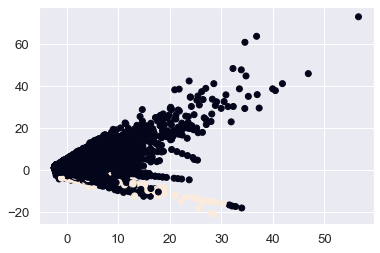

In [45]:
plt.scatter(pca_X['X1'], pca_X['X2'], c=pca_X['Labels'])

We will try the following techniques, but the model will always be constant (Random Forest model).  
  
1. Unbalanced data - Baseline model  
2. Balanced data - Equal sampling  
3. Oversampled data - Resampled data for 1's and same 0's  
4. Bayesian Hyperparameter optimization 
5. SMOTE analysis  
6. ADASYN analysis  
7. Outlier detection  
  
These techniques that are described above are industry standard techniques. We will build models and evaluate final metrics and get an idea of what is happening. Finally, I want to show a concept work I have done in this area. Using a deep learning methodology for __data augmentation GAN's__, we will see how to tackle imbalanced classification exercise.  

## 4.0 Model builing and evaluation functions

In [27]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [28]:
def build_model(X, y):

    clf = RandomForestClassifier()
    clf.fit(X, y)
    return clf

In [29]:
def evaluate_model(clf, X, y):
    
    pred = clf.predict(X) #predicted classes
    accuracy = accuracy_score(pred,y) # calculate accuracy
    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1]) # roc_curve
    auc_value = auc(fpr,tpr) # auc_value
    report = classification_report(y, pred, labels=[0,1], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.reset_index()
    model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
    model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
    model_eval['ROC']  = auc_value
    cf_matrix = confusion_matrix(y, pred)
    
    return model_eval, cf_matrix

In [30]:
def model_eval_data(clf, X_train, y_train, 
                         X_test, y_test, 
                         model_eval_train, 
                         model_eval_test,
                         Name=None):
    
    temp_eval_train, cf_matrix_train = evaluate_model(clf, X_train, y_train)
    temp_eval_test, cf_matrix_test = evaluate_model(clf, X_test, y_test)
    temp_eval_train.index = [Name]
    temp_eval_test.index = [Name]
    
    try:
        model_eval_train = model_eval_train.append(temp_eval_train)
        model_eval_test = model_eval_test.append(temp_eval_test)
    except:
        model_eval_train = temp_eval_train
        model_eval_test = temp_eval_test
    
    return model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test

In [31]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [96]:
model_eval_train = pd.DataFrame({},[])
model_eval_test = pd.DataFrame({},[])

## 4.1 Unbalanced data - Baseline model

In [97]:
clf = build_model(X_train, y_train)

In [98]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='Unbalanced data - Baseline model')

In [99]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.0,0.994302,0.997143,0.99999,1.0


In [100]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.80916,0.999415,0.952141


### 4.1.1 Final conclusion

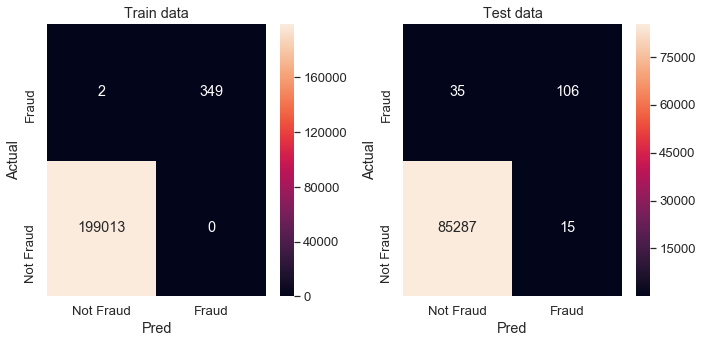

In [101]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

The model is performing well on the training data, but underperforms on the test data. This is an typical example of overfitting.

## 4.2 Balanced data - Equal sampling

I am going to use the datasets created in step 3.4 (new_X, new_y)

In [102]:
new_X = new_X[selected_vars]

In [103]:
clf = build_model(new_X, new_y)
balanced_data_eval, _ = evaluate_model(clf, new_X, new_y)

In [104]:
balanced_data_eval

,precision,recall,f1-score,accuracy,ROC
1,1.0,1.0,1.0,1.0,1.0


In [105]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='Balanced data')

In [106]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.000000,0.994302,0.997143,0.999990,1.000000
Balanced data,0.050121,1.000000,0.095458,0.966634,0.999341


In [107]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067


### 4.2.1 Final conclusion

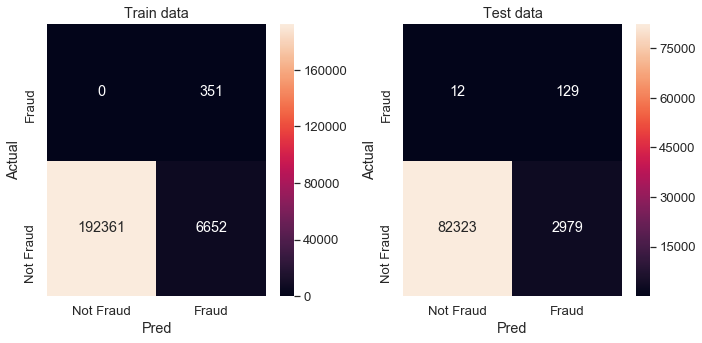

In [108]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

This model produces a lot of false positives. That is why, we see a low precision  and f1-score in the output. 

## 4.3 Oversampled data - Resampled data for 1's and same 0's

In [109]:
from sklearn.utils import resample

df_zeros = df_train[df_train.Class == 0]
df_ones = df_train[df_train.Class == 1]

In [110]:
len(df_zeros)

199013

In [111]:
# Upsample minority class
df_ones_upsampled = resample(df_ones, 
                            replace=True,     # sample with replacement
                            n_samples=20000,  # change this number as we want
                            random_state=42) # reproducible results

In [112]:
df_upsampled = pd.concat([df_zeros, df_ones_upsampled])

In [113]:
df_upsampled.Class.value_counts()

0    199013
1     20000
Name: Class, dtype: int64

In [114]:
X_upsampled, y_upsampled = splitXY(df_upsampled, 'Class')

In [115]:
X_upsampled = X_upsampled[selected_vars]

In [116]:
clf = build_model(X_upsampled, y_upsampled)
upsampled_data_eval, _ = evaluate_model(clf, X_upsampled, y_upsampled)

In [117]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='Resampled data')

In [118]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.000000,0.994302,0.997143,0.999990,1.000000
Balanced data,0.050121,1.000000,0.095458,0.966634,0.999341
Resampled data,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067
Resampled data,0.877049,0.758865,0.813688,0.999427,0.948664


### 4.3.1 Final conclusion

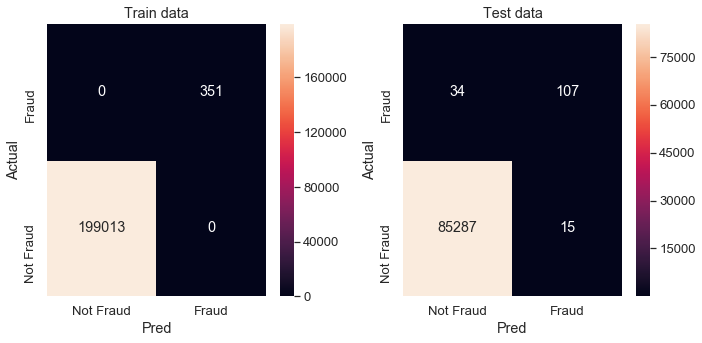

In [120]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

The model is still overfitting on the training data as we can see from the results. However, it performs a little better than original data. This proves that resampling techniques might work for this data.

## 4.4 Bayesian Hyperparameter optimization

In [128]:
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin
from hyperopt.pyll import scope
from sklearn.model_selection import cross_val_score

In [129]:
MAX_EVALS = 50

In [135]:
def objective(params):
    
    clf = RandomForestClassifier(**params)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    best_score = max(scores) # Extract the best score
    loss = 1 - best_score # Loss must be minimized

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [136]:
space = {
    'max_features': hp.choice('max_features', ['auto', 'sqrt']),
    'bootstrap' : hp.choice('bootstrap', [True, False]),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 1, 5, 1))
}

In [137]:
tpe_algorithm = tpe.suggest # Algorithm
bayes_trials = Trials() # Trials object to track progress
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials) # Optimize

100%|██████████| 50/50 [48:11<00:00, 57.82s/trial, best loss: 0.09090909090909105]


In [139]:
best

{'bootstrap': 1,
 'max_depth': 11.0,
 'max_features': 1,
 'min_samples_leaf': 2.0,
 'min_samples_split': 2.0,
 'n_estimators': 21.0}

In [146]:
for key, value in best.items():
    best[key] = int(value)

In [147]:
clf = RandomForestClassifier(**best)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=1, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [148]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='Bayesian Hyperparameter Optimization')

In [149]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.000000,0.994302,0.997143,0.999990,1.000000
Balanced data,0.050121,1.000000,0.095458,0.966634,0.999341
Resampled data,1.000000,1.000000,1.000000,1.000000,1.000000
Bayesian Hyperparameter Optimization,0.979592,0.820513,0.893023,0.999654,0.996080


In [150]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067
Resampled data,0.877049,0.758865,0.813688,0.999427,0.948664
Bayesian Hyperparameter Optimization,0.895652,0.730496,0.804688,0.999415,0.968042


### 4.4.1 Final Conclusion

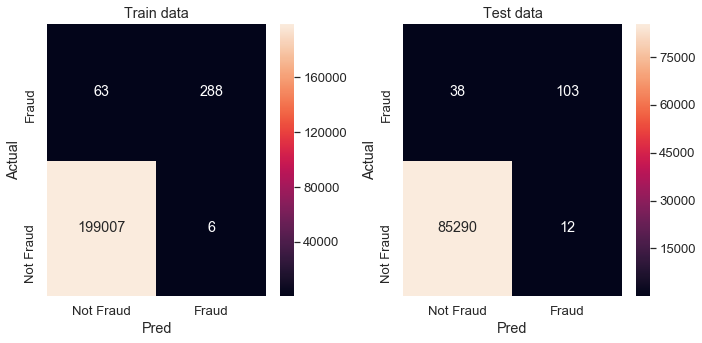

In [151]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

The hyperparameter optimized model showed good results in training and little improvement in the overall methodology, however still the model is not performing well in the test data.

## 4.5 SMOTE

In [155]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
smoteX, smoteY = sm.fit_sample(X_train, y_train)

In [160]:
print('#No. of Zeros - ', len(smoteY) - np.sum(smoteY))
print('#No. of Ones - ', np.sum(smoteY))

#No. of Zeros -  199013
#No. of Ones -  199013


In [161]:
clf = build_model(smoteX, smoteY)

In [162]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='SMOTE Analysis')

In [163]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.000000,0.994302,0.997143,0.999990,1.000000
Balanced data,0.050121,1.000000,0.095458,0.966634,0.999341
Resampled data,1.000000,1.000000,1.000000,1.000000,1.000000
Bayesian Hyperparameter Optimization,0.979592,0.820513,0.893023,0.999654,0.996080
SMOTE Analysis,1.000000,1.000000,1.000000,1.000000,1.000000


In [164]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067
Resampled data,0.877049,0.758865,0.813688,0.999427,0.948664
Bayesian Hyperparameter Optimization,0.895652,0.730496,0.804688,0.999415,0.968042
SMOTE Analysis,0.785714,0.780142,0.782918,0.999286,0.965147


### 4.5.1 Final Conclusion

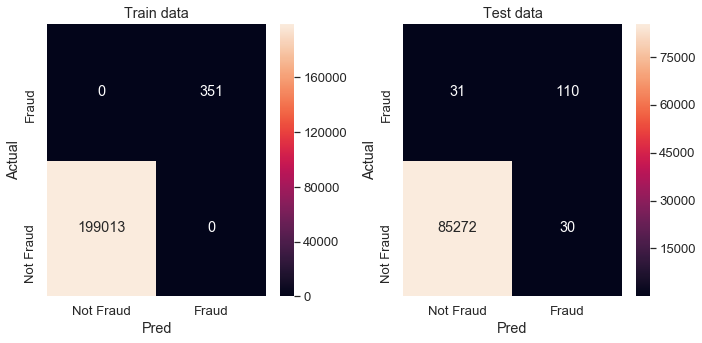

In [165]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

SMOTE is also overfitting on the training dataset, however on the test dataset it is able to produce a balanced result when compared to other methods. 

## 4.6 ADASYN

In [166]:
from imblearn.over_sampling import ADASYN 
ada = ADASYN()
adaX, aday = ada.fit_sample(X_train, y_train)

In [167]:
print('#No. of Zeros - ', len(adaX) - np.sum(aday))
print('#No. of Ones - ', np.sum(aday))

#No. of Zeros -  199013
#No. of Ones -  199007


In [168]:
clf = build_model(adaX, aday)

In [169]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='ADASYN Analysis')

In [170]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.000000,0.994302,0.997143,0.999990,1.000000
Balanced data,0.050121,1.000000,0.095458,0.966634,0.999341
Resampled data,1.000000,1.000000,1.000000,1.000000,1.000000
Bayesian Hyperparameter Optimization,0.979592,0.820513,0.893023,0.999654,0.996080
SMOTE Analysis,1.000000,1.000000,1.000000,1.000000,1.000000
ADASYN Analysis,1.000000,1.000000,1.000000,1.000000,1.000000


In [171]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067
Resampled data,0.877049,0.758865,0.813688,0.999427,0.948664
Bayesian Hyperparameter Optimization,0.895652,0.730496,0.804688,0.999415,0.968042
SMOTE Analysis,0.785714,0.780142,0.782918,0.999286,0.965147
ADASYN Analysis,0.751724,0.773050,0.762238,0.999204,0.965654


### 4.6.1 Final Conclusion

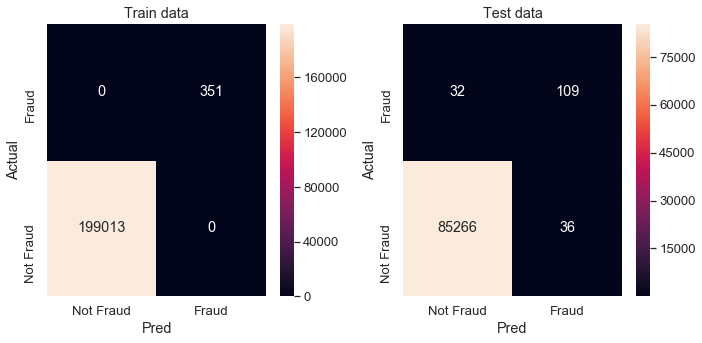

In [172]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

ADASYN is performing more or less like SMOTE, but not better than SMOTE. But it is a good try.

## 4.7 Outlier detection

In [173]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(nu=0.01)

In [211]:
def rearrange_data(X, y):
    
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    freshX = np.r_[X_zeros, X_ones]
    freshy = np.r_[[1] * len(y_zeros), [-1] * len(y_ones)]
    
    return X_zeros, y_zeros, freshX, freshy

In [212]:
train_X_zeros, train_y_zeros, train_freshX, train_freshy = rearrange_data(X_train, y_train)
test_X_zeros, test_y_zeros, test_freshX, test_freshy = rearrange_data(X_test, y_test)

In [214]:
clf.fit(train_X_zeros)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

In [215]:
pred_train = clf.predict(train_freshX)
pred_test = clf.predict(test_freshX)

In [216]:
np.unique(pred_train) #finding the unique values in pred_train

array([-1,  1])

### 4.7.1 Model evaluation

In [229]:
def outlier_model_evaluation(y, pred):
    
    accuracy = accuracy_score(pred,y) # calculate accuracy
    fpr, tpr, _ = roc_curve(y, pred) # roc_curve
    auc_value = auc(fpr,tpr) # auc_value
    report = classification_report(y, pred, labels=[-1,1], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.reset_index()
    model_eval  = report_df[report_df['index'].str.contains('-1')][['precision','recall','f1-score']]
    model_eval['accuracy']  = accuracy
    model_eval['ROC']  = auc_value
    cf_matrix = confusion_matrix(y, pred)
    
    return model_eval, cf_matrix

In [230]:
temp_eval_train, cf_matrix_train = outlier_model_evaluation(train_freshy, pred_train)
temp_eval_test, cf_matrix_test = outlier_model_evaluation(test_freshy, pred_test)

In [232]:
temp_eval_train.index = ['Outlier detection using SVM']
temp_eval_test.index = ['Outlier detection using SVM']

In [233]:
model_eval_train = model_eval_train.append(temp_eval_train)
model_eval_test = model_eval_test.append(temp_eval_test)

In [234]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.000000,0.994302,0.997143,0.999990,1.000000
Balanced data,0.050121,1.000000,0.095458,0.966634,0.999341
Resampled data,1.000000,1.000000,1.000000,1.000000,1.000000
Bayesian Hyperparameter Optimization,0.979592,0.820513,0.893023,0.999654,0.996080
SMOTE Analysis,1.000000,1.000000,1.000000,1.000000,1.000000
ADASYN Analysis,1.000000,1.000000,1.000000,1.000000,1.000000
Outlier detection using SVM,0.126632,0.829060,0.219706,0.989632,0.909488


In [235]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067
Resampled data,0.877049,0.758865,0.813688,0.999427,0.948664
Bayesian Hyperparameter Optimization,0.895652,0.730496,0.804688,0.999415,0.968042
SMOTE Analysis,0.785714,0.780142,0.782918,0.999286,0.965147
ADASYN Analysis,0.751724,0.773050,0.762238,0.999204,0.965654
Outlier detection using SVM,0.106787,0.836879,0.189406,0.988179,0.912654


### 4.7.2 Final Conclusion

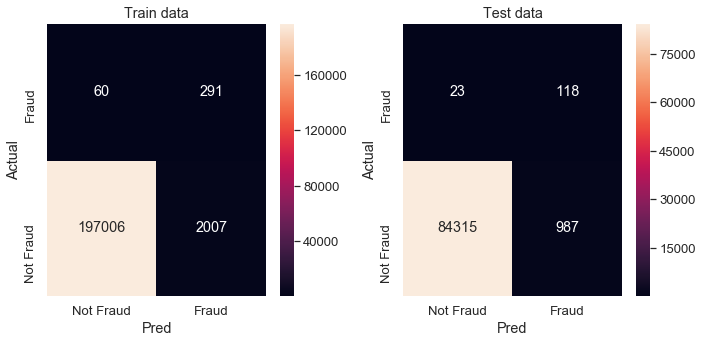

In [242]:
make_confusion_matrix_chart(np.flip(cf_matrix_train), np.flip(cf_matrix_test))

Well it worth a try. We got a good recall in both train and test using Outlier detection technique, however, the precision too bad. 

# 5. GAN based data augmentation - My idea for imbalanced classification

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
def generator(z, reuse=None):
    with tf.variable_scope("gen", reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z, units=128)
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1, units=64)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        output = tf.layers.dense(hidden2, units=15, activation=tf.nn.tanh)
        return output

In [48]:
def discriminator(X, reuse=None):
    with tf.variable_scope("dis", reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X, units=128)
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        logits = tf.layers.dense(hidden2, units=1)
        output = tf.sigmoid(logits)
        return output, logits

In [49]:
real_data = tf.placeholder(tf.float32, shape=[None, 15])
z = tf.placeholder(tf.float32, shape=[None, 100])

In [50]:
G = generator(z)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [51]:
D_output_real, D_logits_real = discriminator(real_data)
D_output_fake, D_logits_fake  = discriminator(G, reuse=True)

In [52]:
# LOSS
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

In [53]:
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [54]:
D_loss = D_real_loss + D_fake_loss
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

In [55]:
learning_rate = 0.001
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [56]:
D_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=g_vars)

In [57]:
def next_batch(num, data):
    '''
    Return a total of `num` random samples. 
    '''
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data.iloc[i] for i in idx]

    return np.asarray(data_shuffle)

In [58]:
X_ones = X_train[y_train == 1]

In [59]:
X_ones.shape

(351, 15)

In [60]:
X_ones.reset_index(drop=True, inplace=True)

In [61]:
batch_size = 10
epochs = 5000
init = tf.global_variables_initializer()
samples = []
no_of_samples_to_generate = len(X_train)  - len(X_ones)

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        
        num_batches = len(X_ones) // batch_size
        for i in range(num_batches):

            batch_X = next_batch(batch_size, X_ones)            
            batch_z = np.random.uniform(-1,1, size=(batch_size,100))
            
            _ = sess.run(D_trainer, feed_dict={real_data:batch_X, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
            
        if epoch % 100 == 0:
            print("ON Epoch {}".format(epoch))
        
    sample_z = np.random.uniform(-1,1,size=(no_of_samples_to_generate, 100)) # new samples will be generated
    gen_sample = sess.run(generator(z, reuse=True), feed_dict={z:sample_z})
    samples.append(gen_sample)

ON Epoch 0
ON Epoch 100
ON Epoch 200
ON Epoch 300
ON Epoch 400
ON Epoch 500
ON Epoch 600
ON Epoch 700
ON Epoch 800
ON Epoch 900
ON Epoch 1000
ON Epoch 1100
ON Epoch 1200
ON Epoch 1300
ON Epoch 1400
ON Epoch 1500
ON Epoch 1600
ON Epoch 1700
ON Epoch 1800
ON Epoch 1900
ON Epoch 2000
ON Epoch 2100
ON Epoch 2200
ON Epoch 2300
ON Epoch 2400
ON Epoch 2500
ON Epoch 2600
ON Epoch 2700
ON Epoch 2800
ON Epoch 2900
ON Epoch 3000
ON Epoch 3100
ON Epoch 3200
ON Epoch 3300
ON Epoch 3400
ON Epoch 3500
ON Epoch 3600
ON Epoch 3700
ON Epoch 3800
ON Epoch 3900
ON Epoch 4000
ON Epoch 4100
ON Epoch 4200
ON Epoch 4300
ON Epoch 4400
ON Epoch 4500
ON Epoch 4600
ON Epoch 4700
ON Epoch 4800
ON Epoch 4900


## 5.1 Create the final dataset for classification exercise

In [62]:
np.array(samples[0]).shape

(199013, 15)

In [63]:
X_fake = pd.DataFrame(samples[0], columns=selected_vars)

In [64]:
X_fake.head()

,V11,V12,V3,V19,V7,V14,V1,V4,V21,V2,V18,V16,V17,V9,V10
0,0.999986,-0.994151,-0.252908,0.999985,-0.910987,-1.0,-1.000000,-0.354144,-0.445982,0.168554,-0.615993,0.999880,0.342957,-0.999396,0.653967
1,1.000000,-0.999489,-0.338332,0.999994,-0.979941,-1.0,-1.000000,-0.278645,-0.472332,0.072365,-0.658629,0.999978,0.369555,-0.999964,0.736485
2,0.999999,-0.771998,-0.214728,0.999996,-0.599142,-1.0,-0.993268,-0.438154,-0.426050,0.121456,-0.354798,0.999939,0.679773,-0.974928,0.358208
3,1.000000,0.581436,-0.656820,1.000000,0.996419,-1.0,1.000000,0.436722,0.060571,-0.734934,0.274551,0.999996,0.140656,-0.286134,-0.389249
4,1.000000,0.493375,-0.647888,1.000000,0.983532,-1.0,1.000000,0.387049,-0.035161,-0.615367,0.219702,0.999984,0.346702,-0.389651,-0.318542


In [65]:
X_augmented_data = np.append(X_train, np.array(X_fake), axis=0)
X_augmented_data.shape

(398377, 15)

In [66]:
y_fake = np.ones(no_of_samples_to_generate)
y_augmented_data = np.append(y_train, y_fake, axis=0)
y_augmented_data.shape

(398377,)

## 5.2 Train Test split

In [67]:
from sklearn.model_selection import train_test_split

aug_X_train, aug_X_test, aug_y_train, aug_y_test = train_test_split(X_augmented_data, y_augmented_data, test_size=0.3, random_state=101)

## 5.3 Train a Random Forest model to see how it works

In [68]:
clf = build_model(aug_X_train, aug_y_train)

## 5.4 Note the evaluation is done on the original dataset

In [80]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='GAN model - Baseline')

In [81]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,1.000000,0.994302,0.997143,0.999990,1.000000
Balanced data,0.050121,1.000000,0.095458,0.966634,0.999341
Resampled data,1.000000,1.000000,1.000000,1.000000,1.000000
Bayesian Hyperparameter Optimization,0.979592,0.820513,0.893023,0.999654,0.996080
SMOTE Analysis,1.000000,1.000000,1.000000,1.000000,1.000000
ADASYN Analysis,1.000000,1.000000,1.000000,1.000000,1.000000
Outlier detection using SVM,0.126632,0.829060,0.219706,0.989632,0.909488
GAN model - Baseline,0.985119,0.943020,0.963610,0.999875,0.985456


In [82]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067
Resampled data,0.877049,0.758865,0.813688,0.999427,0.948664
Bayesian Hyperparameter Optimization,0.895652,0.730496,0.804688,0.999415,0.968042
SMOTE Analysis,0.785714,0.780142,0.782918,0.999286,0.965147
ADASYN Analysis,0.751724,0.773050,0.762238,0.999204,0.965654
Outlier detection using SVM,0.106787,0.836879,0.189406,0.988179,0.912654
GAN model - Baseline,0.875000,0.744681,0.804598,0.999403,0.948165


## 5.5 Final Conclusion

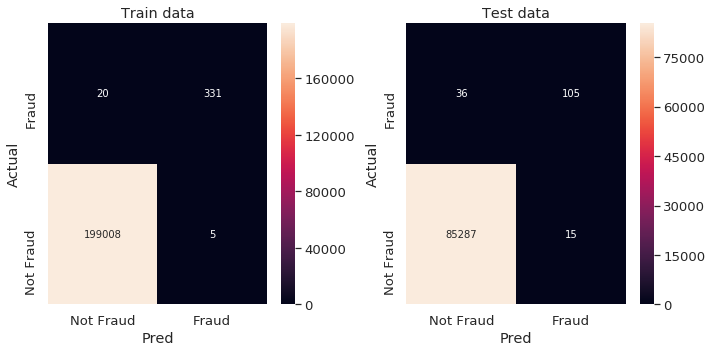

In [84]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

GAN model is definitely doing a great job and the results are comparable to the data augmentation counterparts, we did before like SMOTE, ADASYNC and Data resampling.  

# 6. What we learned from these exercise?

__1. Random forest model is overfitting on the training dataset.__  

_Solution:_ To rectify this effect, we build small trees by reducing the depth parameter and increase the samples for 'min_samples_leaf' option.

__2. Accuracy is not a good metric in evaluating the imbalanced dataset model__

_Reason:_ Most of the times the accuracy is close 99%. This is because even if we classify all our observation as Not fraud, we would get that number. So for imbalanced dataset exercise we should look for other validation metrics like - Precision, Recall or F1-score.  

# 7. Finally, which method is the winner?

In [90]:
final_eval_test = model_eval_test.copy(deep=True)

In [92]:
model_eval_test.reset_index(inplace=True)

In [95]:
model_eval_test.rename({'index': 'Method'}, axis=1, inplace=True)

In [96]:
model_eval_test

,Method,precision,recall,f1-score,accuracy,ROC
0,Unbalanced data - Baseline model,0.876033,0.751773,0.809160,0.999415,0.952141
1,Balanced data,0.041506,0.914894,0.079409,0.964994,0.972067
2,Resampled data,0.877049,0.758865,0.813688,0.999427,0.948664
3,Bayesian Hyperparameter Optimization,0.895652,0.730496,0.804688,0.999415,0.968042
4,SMOTE Analysis,0.785714,0.780142,0.782918,0.999286,0.965147
5,ADASYN Analysis,0.751724,0.773050,0.762238,0.999204,0.965654
6,Outlier detection using SVM,0.106787,0.836879,0.189406,0.988179,0.912654
7,GAN model - Baseline,0.875000,0.744681,0.804598,0.999403,0.948165


In [99]:
tidy = model_eval_test.melt(id_vars='Method').rename(columns=str.title)

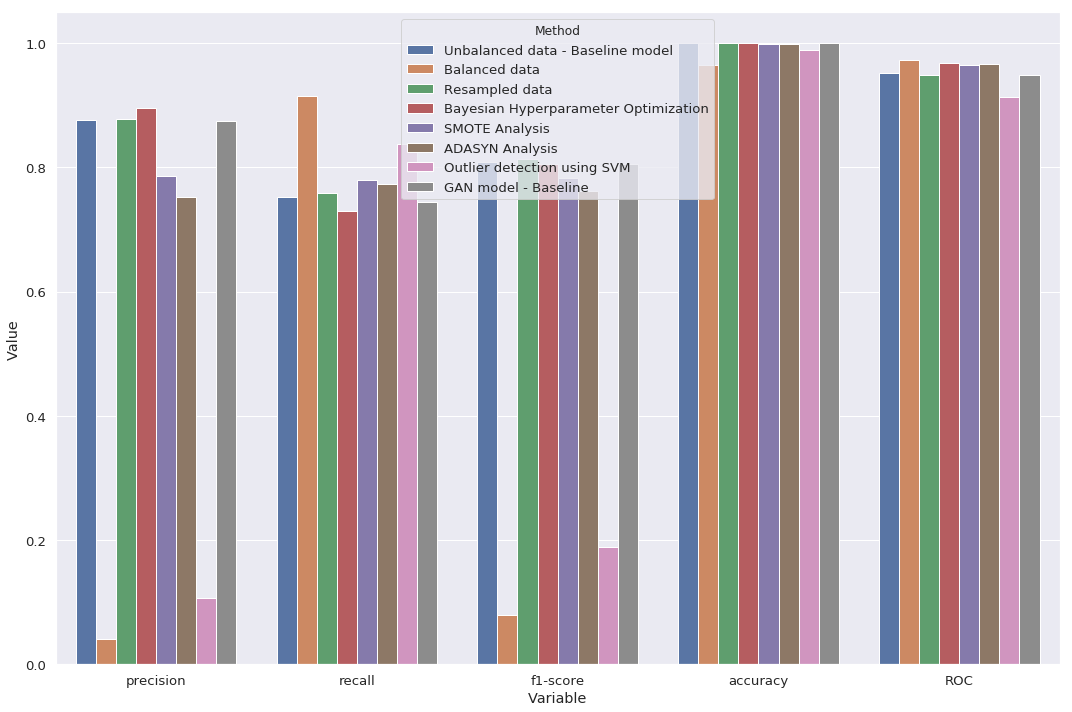

In [111]:
plt.figure(figsize=(15,10))
sns.barplot(x='Variable', y='Value', hue='Method', data=tidy)
plt.tight_layout()

__Precision__ Model Winner, Runner - Bayesian Hyperparameter Optimization, Resampled data  
__Recall__ Model Winner, Runner - Balanced data, Outlier detection using SVM   
__F1-score__ Winner, Runner - Resampled data, Unbalanced data - Baseline model  
__ROC__ Winner, Runner - Balanced data, Bayesian Hyperparameter Optimization  

# 8. Can we use deep learning model instead of Random Forest?

We saw that the random forest model is overfitting the training dataset because of the parameters settings like max_depth, min_samples_leaf etc. Can we use deep learning model instead of Random Forest and get a better model? Let us test it out. But this time, we will use the deep learning model on the GAN data and then evaluate our results.

In [180]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def define_model(n_input):
    # define model
    model = Sequential()
    
    # define first layer
    model.add(Dense(15, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    
    # define second layer
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    
    # define second layer
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.5))
    
    # define output layer
    model.add(Dense(1, activation='sigmoid'))
    # define loss and optimizer
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [181]:
n_input = aug_X_train.shape[1]
model = define_model(n_input)

In [182]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_10 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                160       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 55        
_________________________________________________________________
dropout_12 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                

In [184]:
model.fit(aug_X_train, aug_y_train, epochs=15, verbose=1)

Epoch 1/15
278863/278863 [==============================] - 12s 45us/step - loss: 0.0851 - accuracy: 0.9808
Epoch 2/15
278863/278863 [==============================] - 12s 44us/step - loss: 0.0861 - accuracy: 0.9808
Epoch 3/15
278863/278863 [==============================] - 12s 43us/step - loss: 0.0834 - accuracy: 0.9813
Epoch 4/15
278863/278863 [==============================] - 12s 44us/step - loss: 0.0834 - accuracy: 0.9813
Epoch 5/15
278863/278863 [==============================] - 12s 44us/step - loss: 0.0828 - accuracy: 0.9815
Epoch 6/15
278863/278863 [==============================] - 12s 44us/step - loss: 0.0844 - accuracy: 0.9813
Epoch 7/15
278863/278863 [==============================] - 12s 44us/step - loss: 0.0846 - accuracy: 0.9810
Epoch 8/15
278863/278863 [==============================] - 12s 44us/step - loss: 0.0835 - accuracy: 0.9813
Epoch 9/15
278863/278863 [==============================] - 12s 44us/step - loss: 0.0832 - accuracy: 0.9814
Epoch 10/15
278863/278863 [=

In [185]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [186]:
pred_train[pred_train < 0.5] = 0
pred_train[pred_train > 0.5] = 1
pred_test[pred_test < 0.5] = 0
pred_test[pred_test > 0.5] = 1

In [188]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199013
           1       0.81      0.81      0.81       351

    accuracy                           1.00    199364
   macro avg       0.90      0.90      0.90    199364
weighted avg       1.00      1.00      1.00    199364



In [189]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.72      0.77      0.75       141

    accuracy                           1.00     85443
   macro avg       0.86      0.89      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [190]:
cf_matrix_train = confusion_matrix(y_train, pred_train)

In [191]:
cf_matrix_test = confusion_matrix(y_test, pred_test)

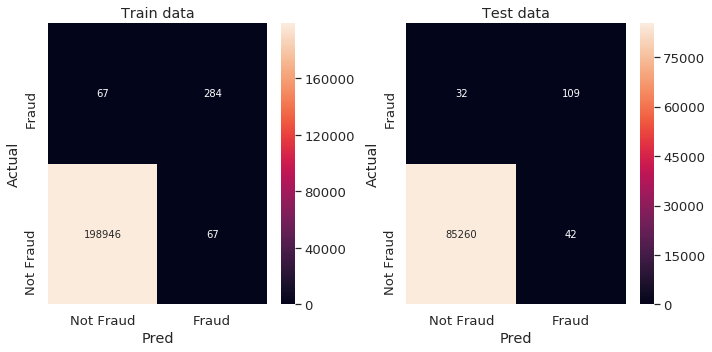

In [192]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

It turns out the deep learning model is performing a little stable when compared to other models, because of the dropout layers. We can further extend this work to run more epochs, add more layers or try a wide neural network settings to see how the model performs. But the overall idea, is we can use GAN's as an alternative to other data augmentation techniques and get comparable results as SMOTE or ADASYNC. 

Have fun!